In [2]:
import sys
sys.path.append('/work/mh0731/m300876/package/')
import icons
import intake
import healpy as hp
import xarray as xr
import numpy as np
import easygems.healpix as egh
from scipy.ndimage import gaussian_filter
from pathlib import Path
import seaborn as sns

In [3]:
### Location mask
def tropics(ds):
    return np.abs(ds.lat) <= 30.1

def equator(ds):
    return np.abs(ds.lat) <= 5.1

def west_pacific(ds):
    return equator(ds) & (ds.lon >= 80.) & (ds.lon <= 160.)

def east_pacific(ds):
    return equator(ds) & (ds.lon >= 200.) & (ds.lon <= 280.)

In [4]:
location = "online"
cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[location]
# list(cat)

### ICON

In [5]:
#zoom数值越大(0-11)，精度越高
ds_icon = cat["icon_d3hp003"](zoom=8, time="P1D").to_dask().pipe(egh.attach_coords)        
time_slice = slice("2020-02-01", "2021-01-31")    #select one year (daily)
psl_icon = ds_icon.psl.where(tropics(ds_icon)).sel(time=time_slice).mean("time").compute()

### NICAM

In [6]:
ds_nicam = cat["nicam_gl11"](zoom=8, time="PT3H").to_dask()
ds_nicam = ds_nicam.assign_coords(              
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)
time_slice = slice("2020-04-01", "2021-03-31")              #select one year (every 3 hour)
psl_nicam = ds_nicam.psl.where(tropics(ds_nicam)).sel(time=time_slice).mean('time').compute()

### Unified Model

In [7]:
ds_um = cat["um_glm_n2560_RAL3p3"](zoom=8, time="PT1H").to_dask()
ds_um = ds_um.assign_coords(              
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)
time_slice = slice("2020-03-01", "2021-03-01")
psl_um = ds_um.psl.where(tropics(ds_um)).sel(time=time_slice).mean('time').compute()

### CAS

In [10]:
ds_cas = cat["casesm2_10km_nocumulus"](zoom=8, time="PT3H").to_dask()
ds_cas = ds_cas.assign_coords(              
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)
time_slice = slice("2020-03-01", "2021-03-01")
psl_cas = ds_cas.psl.where(tropics(ds_cas)).sel(time=time_slice).mean('time').compute()
psl_cas

<xarray.DataArray 'psl' (cell: 786432)> Size: 3MB
array([101064.51 , 101064.1  , 101063.7  , ..., 101078.45 , 101077.445,
       101078.26 ], shape=(786432,), dtype=float32)
Coordinates:
    crs      float32 4B nan
    lat      (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.2984 -0.1492
    lon      (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Dimensions without coordinates: cell

### Walker Cell Index

In [11]:
pwc_icon = psl_icon.where(east_pacific).mean()-psl_icon.where(west_pacific).mean()
pwc_nicam = psl_nicam.where(east_pacific).mean()-psl_nicam.where(west_pacific).mean()
pwc_um = psl_um.where(east_pacific).mean()-psl_um.where(west_pacific).mean()
pwc_cas = psl_cas.where(east_pacific).mean()-psl_cas.where(west_pacific).mean()

### Plotting

In [12]:
# import pyicon as pyic
import cartopy as cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.patches import Polygon

### Saptial Pattern

In [ ]:
###Custom plot for troics
def add_region(ax, lon_range, lat_range, color='red'):
    """Helper function to add rectangular regions"""
    # 定义矩形区域 [左下经度, 左下纬度, 宽度, 高度] 
    rect = mpatches.Rectangle(
        (lon_range[0], lat_range[0]),
        lon_range[1] - lon_range[0],
        lat_range[1] - lat_range[0],
        linewidth=2, edgecolor=color, facecolor='none',
        transform=ccrs.PlateCarree()
        )
    
    ax.add_patch(rect)
    return rect

def tropdmap(var, pwc_value=None, **kwargs):
    projection = ccrs.PlateCarree(central_longitude=-135.5808361)
    sns.set_context("paper")
    fig, ax = plt.subplots(
        figsize=(16/2.54, 16/2.54), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="gray", alpha=0.25)
    cs = egh.healpix_show(var, ax=ax, **kwargs)
    ax.set_ylim(-30,30)
    ax.spines.geo.set_visible(False)

    # 添加经纬度信息
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='grey',linewidth=1,alpha=0.7,zorder=2)
    box = [-180,181,-30,30+1]
    # ax.set_xlim(box[0], box[1])
    # ax.set_ylim(box[2], box[3])
    ax.set_extent(box,crs=projection)
    ax.set_xticks(np.arange(box[0], box[1], 60),crs=projection)
    ax.set_yticks(np.arange(box[2], box[3], 15), crs=projection)
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label =False, number_format='.1f'))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))   #设定minor ticks，间隔为10
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(15))
    
    # colorbar
    cbar = fig.colorbar(cs, orientation='vertical',
                        shrink=0.15, aspect=10, pad=0.01, 
                        extend='both',
                        ticks=np.arange(1000, 1020+1, 4)
                        )
    
    cbar.set_label('hPa')

    # Add standard regions
    add_region(ax, [80, 160], [-5, 5])  # Warm Pool
    add_region(ax, [200, 280], [-5, 5])  # Eastern Pacific 

    # Add value annotation if provided
    if pwc_value is not None:
        ax.text(0.95, 0.95, f'{pwc_value:.2f} hPa', 
                transform=ax.transAxes,
                ha='right', va='top',
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'),
                fontsize=12)

    return ax


Text(0.5, 1.0, 'CAS')

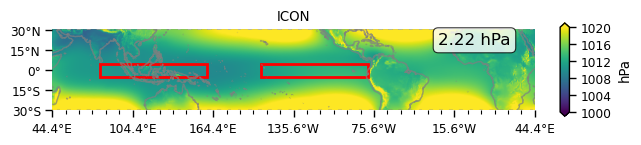

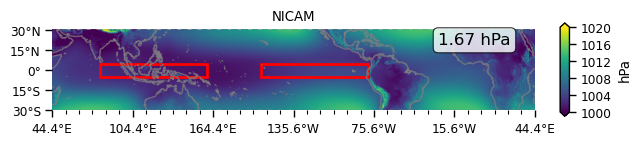

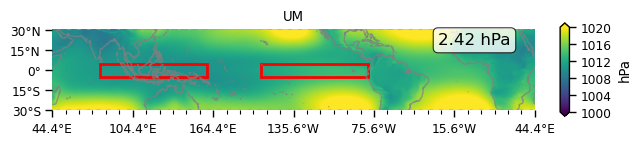

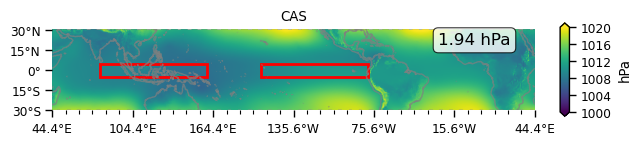

In [ ]:
##Customizing colormap
# cmap_w_b = ListedColormap(["w", "b"])
# bounds_w_b = [0, 0.5]
# norm_w_b = BoundaryNorm(bounds_w_b, cmap_w_b.N)

ax = tropdmap(psl_icon/100, (pwc_icon/100).values, vmin=1000,vmax=1020) 
ax.set_title('ICON')

ax = tropdmap(psl_nicam/100, (pwc_nicam/100).values, vmin=1000,vmax=1020) 
ax.set_title('NICAM')

ax = tropdmap(psl_um/100, (pwc_um/100).values, vmin=1000,vmax=1020) 
ax.set_title('UM')

ax = tropdmap(psl_cas/100, (pwc_cas/100).values, vmin=1000,vmax=1020) 
ax.set_title('CAS')

### Meridional mean